In [15]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import math
import quimb as qu
from pathlib import Path
from matplotlib.colors import LogNorm, Normalize

from itertools import product
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR, CyclicLR, CosineAnnealingLR
from mpl_toolkits.axes_grid1 import make_axes_locatable

from models import Lindbladian
from ml.classes import MLLP
from utils import print_comparison, print_comparison_3, print_omega, print_rates
from sfw.optimizers import Adam
from ml.core import train
from ml.utils import calculate_error, load_data

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'text.latex.preamble': r'\usepackage{bbm}'
})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def print_data(tebd, exp, start, end, ylim, dt=0.01):
    t = np.arange(start*dt, end*dt, dt)[:-1]
        
    rows= 5
    columns = 3
    
    names = ['I1X2', 'I1Y2', 'I1Z2', 'X1I2', 'X1X2', 'X1Y2', 'X1Z2', 'Y1I2', 'Y1X2', 'Y1Y2', 'Y1Z2', 'Z1I2', 'Z1X2', 'Z1Y2', 'Z1Z2']

    fig, axs = plt.subplots(rows, columns, figsize=(15,15), dpi=80)
    plt.setp(axs, xlim=(0,(end-start)*dt), ylim=(-ylim, ylim))

    for i in range(rows):
        for j in range(columns):
            #if i == rows-1 & j == columns-1:
            #    continue
            axs[i, j].plot(t, [tebd[k][columns*i+j] for k in range(len(t))], label='tebd')
            axs[i, j].plot(t, [exp[k][columns*i+j] for k in range(len(t))], label='exp')

            axs[i, j].grid()
            axs[i, j].set_title(names[columns*i+j], x=0.5, y=0.85)
    axs[4, 2].grid()
    #plt.legend()
    plt.grid()

    fig = plt.gcf()
    plt.show()

In [3]:
def create_basis(spin_base):
    """Returns the basis F_i using spin operators in
        represented in the basis 'spin_base'.
        
    e.g. spin_base = 'zx'
    means the spin opertors for the first spin are
    represented in the z-basis, whereas the spin
    operators for the second spin are represented in
    the x-basis.
    """
    paulis = {'z' : {'I' : qu.pauli('I'),
                    'X' : qu.pauli('X'),
                    'Y' : qu.pauli('Y'),
                    'Z' : qu.pauli('Z')},
              'y' : {'I' : qu.pauli('I'),
                    'X' : qu.pauli('Y'),  # X -> Y
                    'Y' : qu.pauli('Z'),  # Y -> Z
                    'Z' : qu.pauli('X')}, # Z -> X
              'x' : {'I' : qu.pauli('I'),
                    'X' : qu.pauli('Z'),  # X -> Z
                    'Y' : -qu.pauli('Y'), # Y -> -Y
                    'Z' : qu.pauli('X')}, # Z -> X
             }
    # the pauli op. in the right basis
    pauli1 = paulis[spin_base[0]]
    pauli2 = paulis[spin_base[1]]
    
    # build the F basis
    F = []
    for ob1, ob2 in product(['I', 'X', 'Y', 'Z'], repeat=2):
        F.append(0.5*pauli1[ob1]&pauli2[ob2])
    return F

In [4]:
def experimental_data(data, N):
    """The function reconstruct the rho, save the diagonal = probability.
    From the probability I can sample -> psi state.
    Having the state I can calculate the expecation value.
    
    Parameters
    ----------
    data : array
        1D array of tebd data len == 15
    N : int
        Number of samples to use
    
    """
    basis = ['xx', 'yy', 'zz', 'xy', 'xz', 'yx', 'yz', 'zx', 'zy']
    
    probability = {}
    for b in basis:
        F_b = create_basis(b)
        rho = np.matrix(np.eye(4, dtype=complex)/4) # the Identity
        for i in range(15):
            rho += data[i]*F_b[i+1]
        probability[b] = np.asarray(rho.diagonal().real)[0]
            
    samples = {}
    for key in probability.keys():
        unique, counts = np.unique(np.random.choice([0,1,2,3], size=N, p=probability[key]), return_counts=True)

        samples[key] = [0, 0, 0, 0]
        for u, c in zip(unique, counts):
            samples[key][u] = c/N
            
    # I need the operator of which calculate the expecation value: either I or sigma Z bacause
    # I put myself always in the right basis
    # Ans the basis in which calculate the expecation value
    operator = ['IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']
    basis    = ['xx', 'yy', 'zz', 'xx', 'xx', 'xy', 'xz', 'yy', 'yx', 'yy', 'yz', 'zz', 'zx', 'zy', 'zz']
    pauli = {'I' : qu.pauli('I').real,
            'X' : qu.pauli('Z').real,
            'Y' : qu.pauli('Z').real,
            'Z' : qu.pauli('Z').real}

    exp_data = [0]*15
    for i in range(15):
        psi = samples[basis[i]]
        op = pauli[operator[i][0]]&pauli[operator[i][1]]*0.5
        exp_data[i] = (op@psi).sum()
        
    return np.array(exp_data)

# Sample the data

In [552]:
prms = {'L': 50,
        'V': 0.5,
        'T': 10,
        'T_test': 20,
        'dt': 0.01,
        'num_traj': 30,
        'N' : 25,       # number of samples for each time and i.c.
        'M' : 25        # number of times for each i.c. # 50,60,70,80
       }

In [553]:
### CREATE - training set
exp_data = {'X' : [],
            'y' : [],
            't' : []}

# import the exact dynamics
gname = 'cohVec_L_' + str(prms['L']) + \
    '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
    '_dt_' + str(int(prms['dt']*1e3)).zfill(4)

with h5py.File('./data/data_tebd.hdf5', 'r') as f:
    data_tebd = f[gname+'/X'][()]
    
t = np.arange(0, prms['T'], prms['dt'])
    
for n in range(prms['num_traj']):
    v_0 = data_tebd[1000*n]
    
    # select some random times at which to sample
    indeces = np.random.choice(range(1, len(t)), prms['M'], replace=False)
    for i in indeces:
        # same initial conditions and time
        exp_data['X'].append(v_0)
        exp_data['t'].append(t[i])
        # the data
        exp_data['y'].append( experimental_data(data_tebd[1000*n+i], N=prms['N']))
        
### SAVE
gname = 'cohVec_L_' + str(prms['L']) + \
        '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
        '_N_' + str(int(prms['N'])) + '_M_' + str(int(prms['M']))

with h5py.File('./data/data_tebd_sampled.hdf5', 'a') as f:
    # create the subgroup
    try:
        subg = f.create_group(gname)
    except:
        subg = f[gname]
        del f[gname+'/X']
        del f[gname+'/y']
        del f[gname+'/t']

    subg.create_dataset('X', data=exp_data['X'])
    subg.create_dataset('y', data=exp_data['y'])
    subg.create_dataset('t', data=exp_data['t'])

# Train the model

In [283]:
def train_model(data_dir, ML_params, PRMS):
    # load the data
    train_loader, eval_loader = load_data(data_dir, PRMS['L'],
                                          PRMS['V'], PRMS['N'], PRMS['M'], PRMS['num_traj'], 
                                          ML_params['batch_size'],
                                          ML_params['validation_split'])
    # create the model
    model = MLLP(ML_params['mlp_params'], potential=0,
                 time_dependent=ML_params['time_dependent']).to(ML_params['device'])

    criterion = torch.nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=0.05)#, betas=[0.3,0.999])
    #scheduler = ExponentialLR(optimizer, 0.99)
    scheduler = MultiStepLR(optimizer, milestones=[300, 350], gamma=0.05)
    #scheduler = CyclicLR(optimizer, base_lr=1e-5, max_lr=1e-2, step_size_up=250, step_size_down=250, mode='triangular', cycle_momentum=False)

    # train the model
    loss = train(model, criterion, optimizer, scheduler, train_loader,
                ML_params['n_epochs'], ML_params['device'],
                epochs_to_prune=[], alpha_1=[1e-4,0], alpha_2=[])

    # name the model
    name = 'model_' + str(PRMS['L']) + \
            '_V_' + str(int(PRMS['V']*1e3)).zfill(4) + \
            '_N_' + str(int(PRMS['N'])) + '_M_' + str(int(PRMS['M']))
    # save the model
    torch.save(model.state_dict(), ML_params['model_dir'] + name)

    plt.plot([i for i in range(1, ML_params['n_epochs']+1)], loss)
    plt.yscale('log')
    plt.grid()

In [69]:
ml_params = {'model_dir': './data/trained/',
             'validation_split': 0,
             'batch_size': 256,
             'time_dependent': False,
             'n_epochs': 400,
             'device': 'cpu',
             'mlp_params': {
                 'data_dim': 15,
                 'layers': [],
                 'nonlin': 'id',
                 'output_nonlin': 'id',
                 'dt': 0.01
                 },
             }
prms = {'L': 50,
        'V': 2,
        'T': 10,
        'T_test': 20,
        'dt': 0.01,
        'num_traj': 30,
        'N' : 20,       # number of samples for each time and i.c.
        'M' : 20        # number of times for each i.c. # 50,60,70,80
       }
# training loop
#for nn in [15,20,25]:
#    for mm in [1,2,3,4,5,10,15,20,25]:
#        prms['N'] = nn
#        prms['M'] = mm
#        print("\n==============================")
#        print(f'N = {nn} M = {mm}')
#        train_model('./data/data_tebd_sampled.hdf5', ml_params, prms)

Data points used in the training 90
=== Mean train loss: 0.070673525333
=== lr: 0.00013


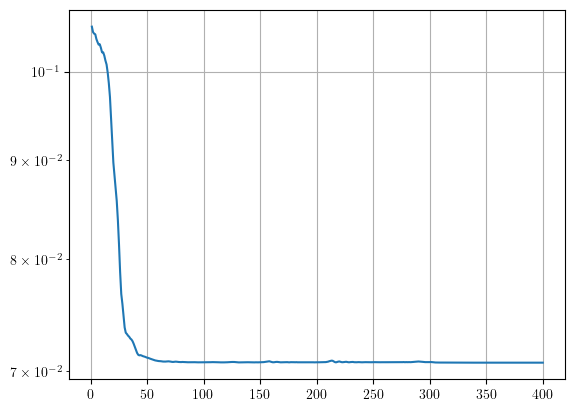

In [567]:
prms['N'] = 3
prms['M'] = 3
train_model('./data/data_tebd_sampled.hdf5', ml_params, prms)

# See performance

In [70]:
name = 'model_' + str(prms['L']) + \
            '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
            '_N_' + str(prms['N']) + '_M_' + str(prms['M'])
model = MLLP(ml_params['mlp_params'], potential=0).to(ml_params['device'])
model.load_state_dict(torch.load(Path('./data/trained/' + name)))

<All keys matched successfully>

In [71]:
# import test data
gname = 'cohVec_L_' + str(prms['L']) + \
    '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
    '_dt_' + str(int(prms['dt']*1e3)).zfill(4)

with h5py.File('./data/data_tebd_test_10.hdf5', 'r') as f:
    data_test = f[gname+'/X'][()]

In [72]:
# calculate the average error
t_ = 1
errors = np.zeros(10)
for i in range(10):
    ml_dyn = model.generate_trajectory(v_0=np.array(data_test[1000*i]), T=10*t_)    
    errors[i] = calculate_error(results_ml=ml_dyn, results_tebd=data_test[1000*i:t_*1000*(i+1)], T=10*t_, dt=0.01)
print(errors.mean())

0.017750185671376047


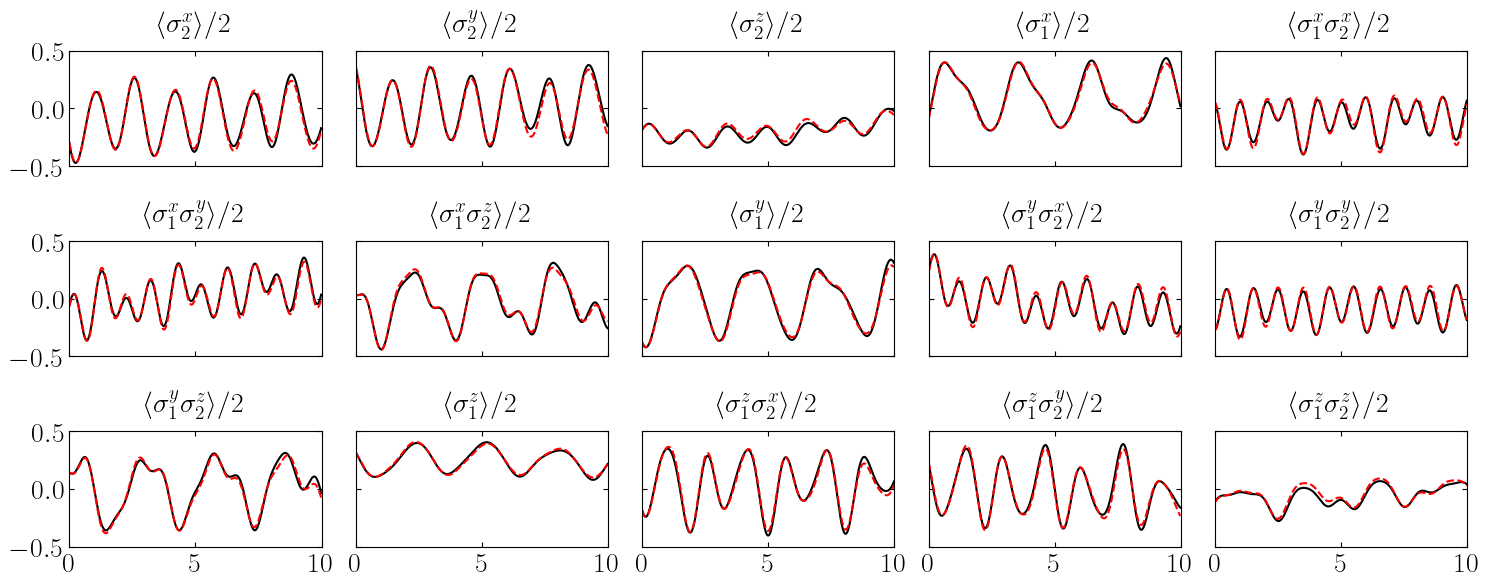

In [73]:
# predict dynamics with the model
indx = 3
ml_dyn = model.generate_trajectory(v_0=np.array(data_test[indx*1000]), T=10*t_)    
print_comparison(data_test[indx*1000:(indx*1000 +1000*t_)], ml_dyn, 10*t_, dt=0.01, ylim=0.5)

# Plot overall

In [560]:
ml_params['model_dir'] = './data/trained/'#_new_initial_conditions/'

In [561]:
prms = {'L': 50,
        'V': 0.5,
        'T': 10,
        'T_test': 20,
        'dt': 0.01,
        'num_traj': 30,
        'N' : 20,       # number of samples for each time and i.c.
        'M' : 20        # number of times for each i.c. # 50,60,70,80
       }

In [568]:
# for each combinations of potential and L I calculate the error
#N = [3,5,10,20,30,40,50,60,70]
#M = [3,5,10,20]#,30,40,50,60,70]
#N = [1,3,5,10,15,20,25,30,35,40]
#M = [1,3,5,10,15,20,25,30,35,40]
N = [1,2,3,4,5,10,15,20,25]
M = [1,2,3,4,5,10,15,20,25]

errors = []

# import test data
gname =  'cohVec_L_' + str(prms['L']) + \
    '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
    '_dt_' + str(int(prms['dt']*1e3)).zfill(4)

with h5py.File('./data/data_tebd_test_10.hdf5', 'r') as f:
    data_test = f[gname+'/X'][()]

for m in M:
    err = []
    for n in N:
        # import the model
        # name the model
        name = 'model_' + str(prms['L']) + \
            '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
            '_N_' + str(n) + '_M_' + str(m)

        model = MLLP(ml_params['mlp_params'], potential=0).to(ml_params['device'])
        model.load_state_dict(torch.load(Path(ml_params['model_dir'] + name)))
        
        # calculate error
        errs = np.zeros(10)
        for i in range(10):
            ml_dyn = model.generate_trajectory(v_0=np.array(data_test[1000*i]), T=10)    
            errs[i] = calculate_error(results_ml=ml_dyn, results_tebd=data_test[1000*i:1000*(i+1)], T=10, dt=0.01)
    
        err.append(errs.mean())
    errors.append(err)

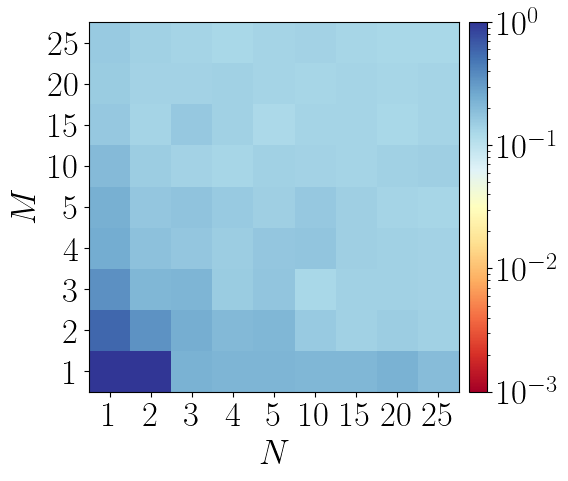

In [570]:
fig, ax = plt.subplots(dpi=100)

im = ax.imshow(errors, origin='lower', cmap='RdYlBu', norm=LogNorm(vmin=0.001, vmax=1))

my_x_ticks = N
my_y_ticks = M
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(['$'+str(i)+'$' for i in my_x_ticks])
ax.set_xlabel(r'$N$', fontsize=25)
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(['$'+str(i)+'$' for i in my_y_ticks])
ax.set_ylabel(r'$M$', fontsize=25)

ax.tick_params(axis='y', labelsize=25)
ax.tick_params(axis='x', labelsize=25)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

cbar = fig.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=25)

plt.show()
#fig.savefig('./plots/V_05.pdf', dpi=150, bbox_inches='tight')

# Plot selected observables

In [194]:
ml_params = {'model_dir': './data/trained_new_initial_conditions/',#_new_initial_conditions/',
             'validation_split': 0,
             'batch_size': 256,
             'time_dependent': False,
             'n_epochs': 400,
             'device': 'cpu',
             'mlp_params': {
                 'data_dim': 15,
                 'layers': [],
                 'nonlin': 'id',
                 'output_nonlin': 'id',
                 'dt': 0.01
                 },
             }
prms = {'L': 50,
        'V': 0.1,
        'T': 10,
        'T_test': 20,
        'dt': 0.01,
        'num_traj': 30,
        'N' : 20,       # number of samples for each time and i.c.
        'M' : 20        # number of times for each i.c. # 50,60,70,80
       }
operator = ['IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']

In [195]:
# import test data
data_indx = 3
gname = 'cohVec_L_' + str(prms['L']) + \
    '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
    '_dt_' + str(int(prms['dt']*1e3)).zfill(4)

with h5py.File('./data/data_tebd_test_10.hdf5', 'r') as f:
    data_test = f[gname+'/X'][()][data_indx*1000:(data_indx+1)*1000]
    
# import model and generate data
model = MLLP(ml_params['mlp_params'], potential=0,
             time_dependent=ml_params['time_dependent']).to(ml_params['device'])
# name the model
name = 'model_' + str(prms['L']) + \
        '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
        '_N_' + str(int(prms['N'])) + '_M_' + str(int(prms['M']))
model.load_state_dict(torch.load(ml_params['model_dir'] + name))

ml_dyn = model.generate_trajectory(v_0=np.array(data_test[0]), T=20) 

/tmp/ipykernel_599414/2324524247.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['$0$','$2.5$','$5$','$7.5$','$10$'])


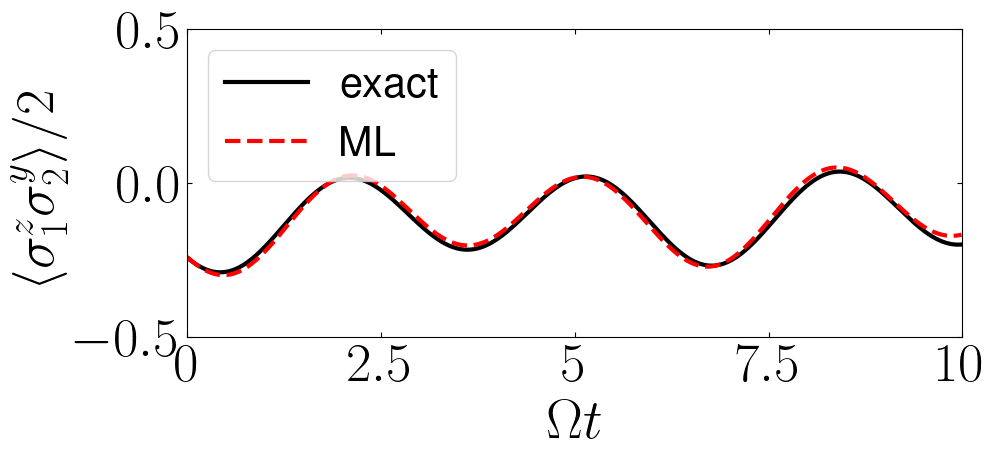

In [196]:
observable = 8   #IX 
observable = 11  #ZI
observable = 13  #ZY

t = np.arange(0, 10, 0.01)

fig, ax = plt.subplots(figsize=(10,4), dpi=100)
ax.plot(t, [data_test[i][observable] for i in range(len(t))], color='black', label='exact', linewidth=3)
ax.plot(t, [ml_dyn[i][observable] for i in range(len(t))], color='red', linestyle='--', label='ML', linewidth=3)
ax.set_ylabel(r'$ \langle \sigma^{z}_{1} \sigma^{y}_{2} \rangle /2$', fontsize=40)
ax.set_ylim([-0.5,0.5])
ax.set_xlim([0,10])
ax.set_xticklabels(['$0$','$2.5$','$5$','$7.5$','$10$'])

ax.tick_params(axis='y', labelsize=40)
ax.tick_params(axis='x', labelsize=40)
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)

ax.set_xlabel(r'$\Omega t$', fontsize=40)
#ax.grid()
ax.legend(fontsize=30)
fig.savefig('./plots/tebd_V01_ob_'+str(observable)+'_'+'_N_' + \
            str(int(prms['N'])) + '_M_' + str(int(prms['M']))+'.pdf', dpi=150, bbox_inches='tight')

# Explicit expression
basis = [IX, IY, IZ, XI, XX, XY, XZ, YI, YX, YY, YZ, ZI, ZX, ZY, ZZ]

In [ ]:
basis = ['IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ', 'ZI', 'ZX', 'ZY', 'ZZ']

prms['V'] = 0.1
prms['N'] = 20
prms['M'] = 20

name = 'model_' + str(prms['L']) + \
            '_V_' + str(int(prms['V']*1e3)).zfill(4) + \
            '_N_' + str(prms['N']) + '_M_' + str(prms['M'])
model = MLLP(ml_params['mlp_params'], potential=0).to(ml_params['device'])
model.load_state_dict(torch.load(Path('./data/trained/' + name)))

<All keys matched successfully>

### Hamiltonian
Ocio *0.5

In [80]:
H = 0.5*model.MLP.omega.detach().numpy().round(2)

hamiltonian = dict(zip(basis,H))
dict(sorted(hamiltonian.items(), key=lambda item: abs(item[1])))

{'XX': -0.0,
 'YY': 0.0,
 'YZ': 0.0,
 'XY': 0.005,
 'XZ': -0.005,
 'YX': -0.005,
 'ZX': -0.005,
 'ZY': 0.005,
 'ZZ': 0.025,
 'IY': -0.03,
 'YI': -0.03,
 'IZ': 0.055,
 'ZI': 0.055,
 'IX': 0.5,
 'XI': 0.5}

### Dissipator

In [81]:
v_x = model.MLP.v_x
v_y = model.MLP.v_y
c_re = torch.add(torch.einsum('ki,kj->ij', v_x, v_x),\
                torch.einsum('ki,kj->ij', v_y, v_y)  )
c_im = torch.add(torch.einsum('ki,kj->ij', v_x, v_y),\
                -torch.einsum('ki,kj->ij', v_y, v_x) )

koss = (c_re + 1j*c_im).detach().numpy()

In [82]:
e_val, e_vec = np.linalg.eig(koss)

In [83]:
e_val.round(3)

array([ 0.013+0.j,  0.   +0.j,  0.   -0.j,  0.   -0.j,  0.   +0.j,
        0.   -0.j,  0.   +0.j,  0.   -0.j,  0.   +0.j,  0.   +0.j,
        0.   -0.j, -0.   -0.j,  0.   +0.j,  0.   -0.j,  0.   -0.j],
      dtype=complex64)

In [84]:
L = 0.5*e_vec[0].round(2)

jump = dict(zip(basis, L))
dict(sorted(jump.items(), key=lambda item: abs(item[1])))

{'IX': (-0+0j),
 'IZ': (0.005+0j),
 'YZ': (0.02+0.035j),
 'ZZ': (-0.03+0.06j),
 'ZX': (0.005+0.08j),
 'ZI': (-0.09+0.02j),
 'ZY': (0.03-0.1j),
 'XX': (0.09-0.065j),
 'XI': (-0.05-0.105j),
 'YX': (-0.09-0.08j),
 'YI': (0.095-0.075j),
 'YY': (0.055+0.145j),
 'XY': (-0.16+0.07j),
 'IY': (0.19-0.1j),
 'XZ': (0.245+0j)}